In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from tqdm import tqdm
import torch
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
from rdkit.Chem import Descriptors, rdmolops
import pickle

In [2]:
#read data
df = pd.read_csv('ligand_properties_unique_hash.csv')
print(len(df))
df.head()

89005


,Ligand_mol2_Strings,Ligand_mol2_Strings_without_X,Ligand_mol2_Strings_without_H,Ligand_mol2_Strings_without_XH,Ligand_Denticities,Graph_Hash_Ligand,Graph_Hash_Ligand_without_X,Graph_Hash_Ligand_without_H,Graph_Hash_Ligand_without_XH,Hemilabile,Connecting_Atom_Indices,Connecting_Atom_Indices_without_H,Connecting_Atom_Indices_without_X,Connecting_Atom_Indices_without_XH,SMILES_without_X_molsimplify,SMILES_without_X_rdkit,Occurrences
0,@<TRIPOS>MOLECULE\nligand\n15\t15\t1\nSMALL\nP...,@<TRIPOS>MOLECULE\n\n14\t14\t1\nSMALL\nPartial...,@<TRIPOS>MOLECULE\n\n11\t11\t1\nSMALL\nPartial...,@<TRIPOS>MOLECULE\n\n10\t10\t1\nSMALL\nPartial...,1,1c7ad85f17b9eff49fe72b778c3c34f6,3e9c127ae89c7d7c70476bc3edd0146d,de1136ccc9f1a20bb65275e3db4200d1,cf794afe3aca095cb66e4686e2c400e9,True,[11],[7],[11],[7],Clc1cccc(c1)C(=O)[O],O=C([O-])c1cccc(Cl)c1,33
1,@<TRIPOS>MOLECULE\nligand\n4\t3\t1\nSMALL\nPar...,@<TRIPOS>MOLECULE\n\n3\t2\t1\nSMALL\nPartialCh...,@<TRIPOS>MOLECULE\n\n2\t1\t1\nSMALL\nPartialCh...,@<TRIPOS>MOLECULE\n\n1\t0\t1\nSMALL\nPartialCh...,1,de39b424f3c3457188364891b9317dba,e5206dd18f7e829cf77fae1a48e7b0b9,d4f3d1d61e49aeb0a0ac5b8b146d86cc,de75f5edfabdb0477e652512e4287161,False,[0],[0],[0],[0],O,O,34348
2,@<TRIPOS>MOLECULE\nligand\n21\t22\t1\nSMALL\nP...,@<TRIPOS>MOLECULE\n\n20\t19\t1\nSMALL\nPartial...,@<TRIPOS>MOLECULE\n\n8\t9\t1\nSMALL\nPartialCh...,@<TRIPOS>MOLECULE\n\n7\t6\t1\nSMALL\nPartialCh...,3,d750f0dd3c8f3f3239ca016adc2e4fd8,03da74c428d73bd0cce03611bc1912b2,4973f8f4fe2953d0cd36790f18f93ec6,0c891e5805b76e96da6ba1df9bddd4b5,True,"[1, 4, 13]","[1, 4, 7]","[0, 3, 12]","[0, 3, 6]",NCCNCCN,NCCNCCN,729
3,@<TRIPOS>MOLECULE\nligand\n15\t15\t1\nSMALL\nP...,@<TRIPOS>MOLECULE\n\n14\t14\t1\nSMALL\nPartial...,@<TRIPOS>MOLECULE\n\n8\t8\t1\nSMALL\nPartialCh...,@<TRIPOS>MOLECULE\n\n7\t7\t1\nSMALL\nPartialCh...,1,b96a9c7f7079d2d2d6f17e3c963742ce,6f7dcaf05c67ea0280785c1da69f60be,3f4a40869b0294b5c284a65d20a3b274,92988d01351387cb00626cb5652e8fc3,True,[0],[0],[0],[0],CC1=CC=[C]C=C1,Cc1cc[c]cc1,175
4,@<TRIPOS>MOLECULE\nligand\n12\t13\t1\nSMALL\nP...,@<TRIPOS>MOLECULE\n\n11\t11\t1\nSMALL\nPartial...,@<TRIPOS>MOLECULE\n\n8\t9\t1\nSMALL\nPartialCh...,@<TRIPOS>MOLECULE\n\n7\t7\t1\nSMALL\nPartialCh...,2,04297c886adca1ea304eed3f9ee37da5,78571a62707b266b7547ec8fad857d32,3e1ceb0125d14567937ae2291ce697a7,e491c8dae119d25956bda1315728fc54,True,"[9, 11]","[5, 7]","[9, 10]","[5, 6]",S=C1[CH]C=CC=N1,[S-]c1ccccn1,264


In [3]:
#filter out hemilabile ligands (ambiguous for graph task)
df = df.loc[df['Hemilabile'] == False]
print(len(df))
df.head()

78672


,Ligand_mol2_Strings,Ligand_mol2_Strings_without_X,Ligand_mol2_Strings_without_H,Ligand_mol2_Strings_without_XH,Ligand_Denticities,Graph_Hash_Ligand,Graph_Hash_Ligand_without_X,Graph_Hash_Ligand_without_H,Graph_Hash_Ligand_without_XH,Hemilabile,Connecting_Atom_Indices,Connecting_Atom_Indices_without_H,Connecting_Atom_Indices_without_X,Connecting_Atom_Indices_without_XH,SMILES_without_X_molsimplify,SMILES_without_X_rdkit,Occurrences
1,@<TRIPOS>MOLECULE\nligand\n4\t3\t1\nSMALL\nPar...,@<TRIPOS>MOLECULE\n\n3\t2\t1\nSMALL\nPartialCh...,@<TRIPOS>MOLECULE\n\n2\t1\t1\nSMALL\nPartialCh...,@<TRIPOS>MOLECULE\n\n1\t0\t1\nSMALL\nPartialCh...,1,de39b424f3c3457188364891b9317dba,e5206dd18f7e829cf77fae1a48e7b0b9,d4f3d1d61e49aeb0a0ac5b8b146d86cc,de75f5edfabdb0477e652512e4287161,False,[0],[0],[0],[0],O,O,34348
7,@<TRIPOS>MOLECULE\nligand\n59\t65\t1\nSMALL\nP...,@<TRIPOS>MOLECULE\n\n58\t63\t1\nSMALL\nPartial...,@<TRIPOS>MOLECULE\n\n35\t41\t1\nSMALL\nPartial...,@<TRIPOS>MOLECULE\n\n34\t39\t1\nSMALL\nPartial...,2,9fef564ea79975a6449d26c1d566e979,443be437456406b5b53912b8677a7cf0,cd2e2eed813f70388f2ec8df9d0e56a8,a5a7fada40021a86542fd33ee525bf92,False,"[25, 54]","[15, 32]","[24, 53]","[14, 31]",C(/N=C\c1c2ccccc2cc2c1cccc2)C/N=C\c1c2ccccc2cc...,C(=N\CC/N=C\c1c2ccccc2cc2ccccc12)\c1c2ccccc2cc...,8
14,@<TRIPOS>MOLECULE\nligand\n43\t45\t1\nSMALL\nP...,@<TRIPOS>MOLECULE\n\n42\t43\t1\nSMALL\nPartial...,@<TRIPOS>MOLECULE\n\n23\t25\t1\nSMALL\nPartial...,@<TRIPOS>MOLECULE\n\n22\t23\t1\nSMALL\nPartial...,2,5e345acbd7f6b7d17eb7439ae257d91a,971623f827bed88eb1ab1a98136f93ac,1398669d878f451d70241feefaa02b7f,19e81007c34455c905c61388d6c06b64,False,"[1, 2]","[1, 2]","[0, 1]","[0, 1]",N(=C\C=C\c1ccccc1)/CC/N=C/C=C/c1ccccc1,C(=C/c1ccccc1)\C=N\CC/N=C/C=C/c1ccccc1,18
17,@<TRIPOS>MOLECULE\nligand\n52\t60\t1\nSMALL\nP...,@<TRIPOS>MOLECULE\n\n51\t55\t1\nSMALL\nPartial...,@<TRIPOS>MOLECULE\n\n31\t39\t1\nSMALL\nPartial...,@<TRIPOS>MOLECULE\n\n30\t34\t1\nSMALL\nPartial...,5,2abf836f471ce46245bae84267c34c8b,db2fdf82099e8b48040016766bb86cc2,91e69ec3abf2d01f61def18c2cb0f738,eafdd65e231db1691a7fa40bbfd96c21,False,"[24, 30, 25, 28, 27]","[24, 30, 25, 28, 27]","[23, 29, 24, 27, 26]","[23, 29, 24, 27, 26]",CN1/N=C(\C)/c2cccc(n2)/C(=N/N(c2nc3c4nc1ccc4cc...,Cc1nn(C)c2ccc3ccc4ccc(nc4c3n2)n(C)nc(C)c2cccc1n2,12
19,@<TRIPOS>MOLECULE\nligand\n34\t34\t1\nSMALL\nP...,@<TRIPOS>MOLECULE\n\n33\t33\t1\nSMALL\nPartial...,@<TRIPOS>MOLECULE\n\n14\t14\t1\nSMALL\nPartial...,@<TRIPOS>MOLECULE\n\n13\t13\t1\nSMALL\nPartial...,1,c9484c0eeec162230cd815edc6726d9d,5a73083c48dc99f99dd7417a4162fac2,2368535061b5d373049ddafe5f16e264,685da971a32b477feaac18bff14116af,False,[3],[3],[2],[2],CC(N1[C]N(C(=C1C)C)C(C)C)C,CC1=C(C)N(C(C)C)[C]N1C(C)C,319


In [4]:
#from the mol2's, generate rdkit mol objects

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

labels = []
mol_ls = []
for i, x in tqdm(df.iterrows(), total=len(df)):
    try:
        mol = Chem.MolFromMol2Block(x['Ligand_mol2_Strings_without_X'])
        label_ls = [int(j) for j in x['Connecting_Atom_Indices_without_XH'].strip('[]').replace(',', '').split()]
        mol_ls.append(mol)
        labels.append(label_ls)
    except:
        pass
len(mol_ls)

100%|██████████| 78672/78672 [01:27<00:00, 900.74it/s] 


78672

In [8]:
allowed_atoms = {1, 6, 7, 8, 9, 15, 16, 17, 35, 53} #H, C, N, O, F, P, S, Cl, Br, I
filtered_mol_ls = []
filtered_labels = []
num_failed = 0

#Filter: ensure atoms are those specified above, no radicals (RDKit kekulized correctly)
#Ensure no trivial (1-heavy-atom) ligands, no heavily charged ligands, and ligand size less than 50

for i in tqdm(range(len(mol_ls))):
    #Some of the mol objects fail to generate, skip over those here
    if mol_ls[i] is None:
        num_failed += 1
        continue
    atom_list = [a.GetAtomicNum() for a in mol_ls[i].GetAtoms()]
    if set(atom_list).issubset(allowed_atoms) and \
        Descriptors.NumRadicalElectrons(mol_ls[i]) == 0 and\
        len(atom_list) >= 2 and \
        Chem.GetFormalCharge(mol_ls[i]) <= 2 and Chem.GetFormalCharge(mol_ls[i]) >= -4 and \
        len(atom_list) <= 50:
        filtered_mol_ls.append(mol_ls[i])
        filtered_labels.append(labels[i])
len(filtered_mol_ls), num_failed

100%|██████████| 78672/78672 [00:06<00:00, 12149.01it/s]


(42026, 7970)

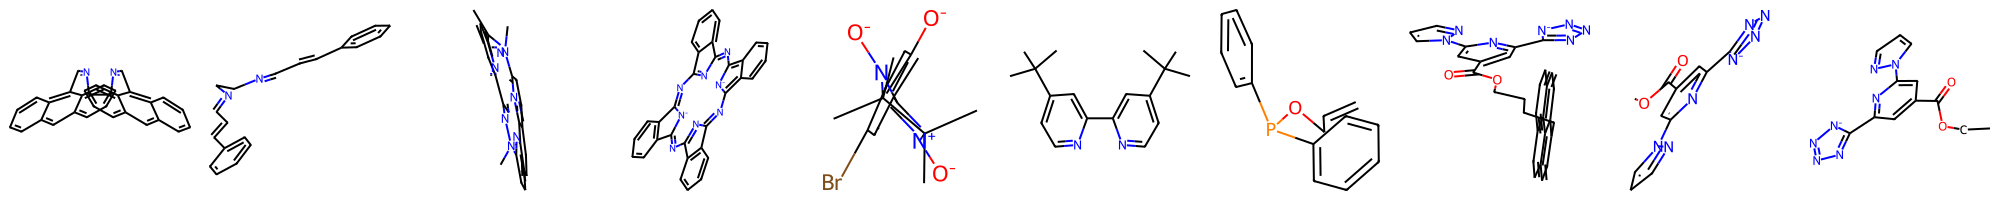

In [9]:
Chem.Draw.MolsToImage(filtered_mol_ls[:10])

In [10]:
# with open('filtered_labels.pkl', 'wb') as f:
#     pickle.dump(filtered_labels, f, protocol=pickle.HIGHEST_PROTOCOL)
# with open('filtered_mol_ls.pkl', 'wb') as f:
#     pickle.dump(filtered_mol_ls, f, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
with open('filtered_labels.pkl', 'rb') as f:
    filtered_labels = pickle.load(f)
with open('filtered_mol_ls.pkl', 'rb') as f:
    filtered_mol_ls = pickle.load(f)

In [11]:
order_string = {
            Chem.rdchem.BondType.SINGLE: np.array([1, 0, 0, 0]),
            Chem.rdchem.BondType.DOUBLE: np.array([0, 1, 0, 0]),
            Chem.rdchem.BondType.TRIPLE: np.array([0, 0, 1, 0]),
            Chem.rdchem.BondType.AROMATIC: np.array([0, 0, 0, 1]),
}

allowed_atoms = [1, 6, 7, 8, 9, 15, 16, 17, 35, 53] #H, C, N, O, F, P, S, Cl, Br, I
atoms_one_hot_key = np.eye(len(allowed_atoms))

def get_features(ligand, label):
    #Get a list of atomic numbers for each ligand
    atoms_one_hot = np.stack([atoms_one_hot_key[allowed_atoms.index(a.GetAtomicNum())] for a in ligand.GetAtoms()])
    
    #Get the number of atoms for each ligand
    natoms = len(ligand.GetAtoms())
    
    #Get the adjacency matrix for each ligand
    adj = rdmolops.GetAdjacencyMatrix(ligand)
    
    #Get the edge index list in COO format for each ligand
    edge_index = (adj>0).nonzero()
    
    #Get the edge features (one-hot encoding of the bond type
    feats = np.zeros((4, len(edge_index[0])))
    for i in range(len(edge_index[0])):
        feats[:, i] = order_string[ligand.GetBondBetweenAtoms(int(edge_index[0][i]), int(edge_index[1][i])).GetBondType()]
    edge_feats = feats.T

    #Get the probability of each atom being a connecting atom (0 or 1)
    y = np.zeros(natoms)
    y[np.array(label)] = 1

    return atoms_one_hot, natoms, edge_index, edge_feats, y

atoms_one_hot_list = []
natom_list = []
edge_index_list = []
edge_feats_list = []
y_list = []
num_failed = 0

for idx in tqdm(range(len(filtered_mol_ls))):
    ligand = filtered_mol_ls[idx]
    label = filtered_labels[idx]
    try:
        atoms_one_hot, natoms, edge_index, edge_feats, y = get_features(ligand, label)
        atoms_one_hot_list.append(atoms_one_hot)
        natom_list.append(natoms)
        edge_index_list.append(edge_index)
        edge_feats_list.append(edge_feats)
        y_list.append(y)
    except:
        num_failed += 1

len(atoms_one_hot_list), num_failed

100%|██████████| 42026/42026 [00:08<00:00, 4937.45it/s]


(41996, 30)

In [10]:
class LigandDataset():
    def __init__(self, atoms_one_hot_list, natom_list, edge_index_list, edge_feats_list, y_list):
        self.atoms_one_hot_list = atoms_one_hot_list
        self.natom_list = natom_list
        self.edge_index_list = edge_index_list
        self.edge_feats_list = edge_feats_list
        self.y_list = y_list
        
    def __len__(self):
        return len(self.y_list)
        
    def __getitem__(self, idx):
        return Data(x=torch.Tensor(self.atoms_one_hot_list[idx]),
                    natoms=torch.Tensor([self.natom_list[idx]]),
                    edge_index=torch.Tensor(np.array(self.edge_index_list[idx])),
                    edge_attr=torch.Tensor(self.edge_feats_list[idx]),
                    y=torch.Tensor(self.y_list[idx])
                   )

data = LigandDataset(atoms_one_hot_list, natom_list, edge_index_list, edge_feats_list, y_list)